In [1]:
import pandas as pd

data = pd.read_csv('house_sales.csv')

#data Has 1500 rows, 8 columns
data.head()

,house_id,city,sale_price,sale_date,months_listed,bedrooms,house_type,area
0,1217792,Silvertown,55943,2021-09-12,5.4,2,Semi-detached,107.8 sq.m.
1,1900913,Silvertown,384677,2021-01-17,6.3,5,Detached,498.8 sq.m.
2,1174927,Riverford,281707,2021-11-10,6.9,6,Detached,542.5 sq.m.
3,1773666,Silvertown,373251,2020-04-13,6.1,6,Det.,528.4 sq.m.
4,1258487,Silvertown,328885,2020-09-24,8.7,5,Detached,477.1 sq.m.


In [2]:
#Cleaning Each Column of  The Data


#Checking Out for Missing Cities

null_cities = data['city'].isnull().sum() #0

unique_cities = data['city'].unique() #['Silvertown', 'Riverford', 'Teasdale', 'Poppleton', '--'],
                                
missing_city = data['city'].str.contains("--").sum() #73


#now lets replace 73 cities with -- as Unknow

data['city'] = data['city'].replace('--', 'Unknown')


#checking Out for Missing Sales Price
missing_price = data['sale_price'].isnull().sum() #0


#checking Out for Missing Dates
missing_dates = data['sale_date'].isnull().sum() #0

#Checking Out Missing Months Listed
missing_months_listed = data['months_listed'].isnull().sum() #31



#Filling The Missing Months Listed
mean_month_listed = round(data['months_listed'].mean(), 1)
data['months_listed'].fillna(mean_month_listed, inplace=True)


#Checking Out For Missing Bed Rooms
missing_bedrooms = data['bedrooms'].isnull().sum() #0



#Checking Out For Missing House Type
#Checking House Type Category

missing_house_type = data['house_type'].isnull().sum() #0
data['house_type'].value_counts()
# Detached         1046
# Semi-detached     231
# Terraced          123
# Det.               78
# Semi               14
# Terr.               8


house_type_mapping = {
    'Det.': 'Detached',
    'Semi': 'Semi-detached',
    'Terr.': 'Terraced'
}




data['house_type'] = data['house_type'].replace(house_type_mapping)
data['house_type'].value_counts()
# Detached         1124
# Semi-detached     245
# Terraced          131


missing_area = data['area'].isnull().sum() #0
# current format of area  107.8 sq.m.


data['area'] = data['area'].astype(str).str.replace("sq.m.", "").astype(float)

#Now we convert our categorical data columns to categorical dtypes

data[['city', 'house_type']] = data[['city', 'house_type']].astype('category')


data['sale_date'] = pd.to_datetime(data['sale_date'])


### `We Check For Outliers`

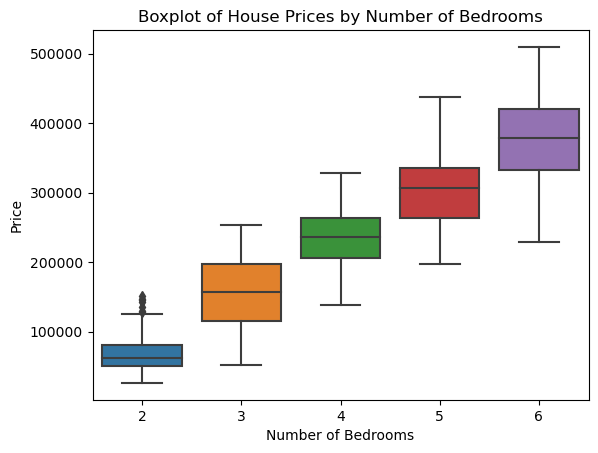

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='bedrooms', y='sale_price', data=data)
plt.title('Boxplot of House Prices by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.show()


clean_data = data.copy()

#### `The Data Has Very little ouliers  at 2 bedrooms`

### Let's Preprocess Our Data

In [64]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

#Selecting Our Features and Target

X = clean_data.drop(columns=['house_id', 'sale_price'])
y = clean_data['sale_price']







numeric_features = ['months_listed', 'bedrooms', 'area']
categorical_features = ['city', 'house_type']


preprocessor = ColumnTransformer(
    transformers=[
        
        ('numeric', Pipeline(steps=[
            ('imputer',SimpleImputer(strategy='mean')),
            
            ('scaler', StandardScaler())
             ]), 
        
        numeric_features),
        
        
        ('category', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
           
        ]), categorical_features)
    ]

)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### `Model Selection`

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np


models = {
    "Liner Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor()
}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    print(f"{name} Mean CV MAE { -np.mean(cv_score)}" )

Liner Regression Mean CV MAE 17252.081871975217
Random Forest Mean CV MAE 11691.352434424605
Gradient Boosting Mean CV MAE 11388.319844965192


`Our best model is Gradient Boosting with least MAE`

###  Hyper Parameter Chunning

In [67]:
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor())
])


param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 4, 5],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__subsample': [0.6, 0.8, 1.0],
   # Valid values for max_features
}


grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')

grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['months_listed',
                                                                          'bedrooms',
                                                                          'area']),
                                                                        ('category',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['city',
                                                                          'house_type'])])),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1],
                         'model__max_depth': [3, 4, 5],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300],
                         'model__subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_absolute_error')

In [54]:
best_model = grid_search.best_estimator_


## Evaluate Model Performance

In [57]:
import sklearn
from sklearn.metrics import r2_score, mean_absolute_percentage_error
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test,y_pred )
mape = mean_absolute_percentage_error(y_test, y_pred)
percentage_error = mape * 100
percentage_error

r2

0.9807691738902673

# Let's Deploy

In [60]:
import joblib

joblib.dump(best_model, 'prediction_app/model.pkl')

clean_data.to_csv('prediction_app/data.csv')